In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [6]:
df = pd.read_csv('../data/united_oats.csv', index_col=0).fillna(0)
y = df['Oat_Yield']
X = df.drop(columns=['Oat_Yield'], axis=1)

In [7]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [9]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [10]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [11]:
X_train.shape

torch.Size([723, 888])

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [13]:
model = LSTM(input_size, hidden_size, num_layers)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

C:\Users\gagyi\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Step [100/241], Loss: 1018.1321
Epoch [1/500], Step [200/241], Loss: 231.3326
Epoch [2/500], Step [100/241], Loss: 111.9658
Epoch [2/500], Step [200/241], Loss: 0.6539
Epoch [3/500], Step [100/241], Loss: 0.2901
Epoch [3/500], Step [200/241], Loss: 58.2385
Epoch [4/500], Step [100/241], Loss: 9.7746
Epoch [4/500], Step [200/241], Loss: 97.6055
Epoch [5/500], Step [100/241], Loss: 17.6008
Epoch [5/500], Step [200/241], Loss: 110.7402
Epoch [6/500], Step [100/241], Loss: 20.1226
Epoch [6/500], Step [200/241], Loss: 115.2755
Epoch [7/500], Step [100/241], Loss: 17.5492
Epoch [7/500], Step [200/241], Loss: 104.8045
Epoch [8/500], Step [100/241], Loss: 58.9097
Epoch [8/500], Step [200/241], Loss: 28.7555
Epoch [9/500], Step [100/241], Loss: 99.9079
Epoch [9/500], Step [200/241], Loss: 58.2337
Epoch [10/500], Step [100/241], Loss: 150.5891
Epoch [10/500], Step [200/241], Loss: 162.0817
Epoch [11/500], Step [100/241], Loss: 103.0696
Epoch [11/500], Step [200/241], Loss: 150.541

Epoch [90/500], Step [200/241], Loss: 98.2562
Epoch [91/500], Step [100/241], Loss: 39.5142
Epoch [91/500], Step [200/241], Loss: 207.3204
Epoch [92/500], Step [100/241], Loss: 433.3590
Epoch [92/500], Step [200/241], Loss: 37.8498
Epoch [93/500], Step [100/241], Loss: 12.1314
Epoch [93/500], Step [200/241], Loss: 201.7732
Epoch [94/500], Step [100/241], Loss: 32.5798
Epoch [94/500], Step [200/241], Loss: 302.1594
Epoch [95/500], Step [100/241], Loss: 13.3614
Epoch [95/500], Step [200/241], Loss: 87.5731
Epoch [96/500], Step [100/241], Loss: 49.2228
Epoch [96/500], Step [200/241], Loss: 66.8314
Epoch [97/500], Step [100/241], Loss: 34.3632
Epoch [97/500], Step [200/241], Loss: 53.0907
Epoch [98/500], Step [100/241], Loss: 339.1286
Epoch [98/500], Step [200/241], Loss: 264.1795
Epoch [99/500], Step [100/241], Loss: 3.0600
Epoch [99/500], Step [200/241], Loss: 41.5058
Epoch [100/500], Step [100/241], Loss: 101.0221
Epoch [100/500], Step [200/241], Loss: 61.1171
Epoch [101/500], Step [100

Epoch [178/500], Step [200/241], Loss: 4.6639
Epoch [179/500], Step [100/241], Loss: 1.0153
Epoch [179/500], Step [200/241], Loss: 2.6691
Epoch [180/500], Step [100/241], Loss: 75.2080
Epoch [180/500], Step [200/241], Loss: 0.0005
Epoch [181/500], Step [100/241], Loss: 50.4259
Epoch [181/500], Step [200/241], Loss: 8.8608
Epoch [182/500], Step [100/241], Loss: 59.5432
Epoch [182/500], Step [200/241], Loss: 9.1012
Epoch [183/500], Step [100/241], Loss: 9.8263
Epoch [183/500], Step [200/241], Loss: 87.6025
Epoch [184/500], Step [100/241], Loss: 10.5965
Epoch [184/500], Step [200/241], Loss: 8.2509
Epoch [185/500], Step [100/241], Loss: 0.0035
Epoch [185/500], Step [200/241], Loss: 1.5066
Epoch [186/500], Step [100/241], Loss: 7.4949
Epoch [186/500], Step [200/241], Loss: 10.4987
Epoch [187/500], Step [100/241], Loss: 0.2199
Epoch [187/500], Step [200/241], Loss: 13.0497
Epoch [188/500], Step [100/241], Loss: 69.2475
Epoch [188/500], Step [200/241], Loss: 146.3558
Epoch [189/500], Step [1

Epoch [266/500], Step [200/241], Loss: 10.5763
Epoch [267/500], Step [100/241], Loss: 0.1052
Epoch [267/500], Step [200/241], Loss: 3.0808
Epoch [268/500], Step [100/241], Loss: 4.0005
Epoch [268/500], Step [200/241], Loss: 0.1090
Epoch [269/500], Step [100/241], Loss: 10.5292
Epoch [269/500], Step [200/241], Loss: 0.4101
Epoch [270/500], Step [100/241], Loss: 229.1177
Epoch [270/500], Step [200/241], Loss: 1.4809
Epoch [271/500], Step [100/241], Loss: 78.9303
Epoch [271/500], Step [200/241], Loss: 0.6875
Epoch [272/500], Step [100/241], Loss: 2.0896
Epoch [272/500], Step [200/241], Loss: 0.2157
Epoch [273/500], Step [100/241], Loss: 14.6137
Epoch [273/500], Step [200/241], Loss: 52.1360
Epoch [274/500], Step [100/241], Loss: 4.9390
Epoch [274/500], Step [200/241], Loss: 3.1620
Epoch [275/500], Step [100/241], Loss: 4.7710
Epoch [275/500], Step [200/241], Loss: 9.7798
Epoch [276/500], Step [100/241], Loss: 17.8141
Epoch [276/500], Step [200/241], Loss: 2.6800
Epoch [277/500], Step [100

Epoch [355/500], Step [100/241], Loss: 1.1189
Epoch [355/500], Step [200/241], Loss: 7.2930
Epoch [356/500], Step [100/241], Loss: 16.3732
Epoch [356/500], Step [200/241], Loss: 0.9163
Epoch [357/500], Step [100/241], Loss: 1.9737
Epoch [357/500], Step [200/241], Loss: 2.9252
Epoch [358/500], Step [100/241], Loss: 1.3536
Epoch [358/500], Step [200/241], Loss: 0.0228
Epoch [359/500], Step [100/241], Loss: 4.9023
Epoch [359/500], Step [200/241], Loss: 0.0493
Epoch [360/500], Step [100/241], Loss: 0.3570
Epoch [360/500], Step [200/241], Loss: 0.0554
Epoch [361/500], Step [100/241], Loss: 3.0835
Epoch [361/500], Step [200/241], Loss: 0.0105
Epoch [362/500], Step [100/241], Loss: 4.1369
Epoch [362/500], Step [200/241], Loss: 0.0303
Epoch [363/500], Step [100/241], Loss: 0.4133
Epoch [363/500], Step [200/241], Loss: 0.1024
Epoch [364/500], Step [100/241], Loss: 0.6081
Epoch [364/500], Step [200/241], Loss: 0.2970
Epoch [365/500], Step [100/241], Loss: 0.0164
Epoch [365/500], Step [200/241], 

Epoch [444/500], Step [100/241], Loss: 0.1146
Epoch [444/500], Step [200/241], Loss: 0.4758
Epoch [445/500], Step [100/241], Loss: 0.3341
Epoch [445/500], Step [200/241], Loss: 0.2053
Epoch [446/500], Step [100/241], Loss: 0.2470
Epoch [446/500], Step [200/241], Loss: 0.9729
Epoch [447/500], Step [100/241], Loss: 0.1184
Epoch [447/500], Step [200/241], Loss: 0.4092
Epoch [448/500], Step [100/241], Loss: 1.2917
Epoch [448/500], Step [200/241], Loss: 0.0003
Epoch [449/500], Step [100/241], Loss: 0.0079
Epoch [449/500], Step [200/241], Loss: 0.0247
Epoch [450/500], Step [100/241], Loss: 1.6538
Epoch [450/500], Step [200/241], Loss: 0.0284
Epoch [451/500], Step [100/241], Loss: 1.2276
Epoch [451/500], Step [200/241], Loss: 0.0155
Epoch [452/500], Step [100/241], Loss: 0.2741
Epoch [452/500], Step [200/241], Loss: 2.8764
Epoch [453/500], Step [100/241], Loss: 13.1433
Epoch [453/500], Step [200/241], Loss: 0.0089
Epoch [454/500], Step [100/241], Loss: 6.9036
Epoch [454/500], Step [200/241], 

In [15]:
weather = X_test.reshape(-1, sequence_length, input_size)
labels = y_test
outputs = model(weather)
loss = criterion(outputs.reshape(-1), labels)
loss

tensor(11.2310, grad_fn=<MseLossBackward0>)

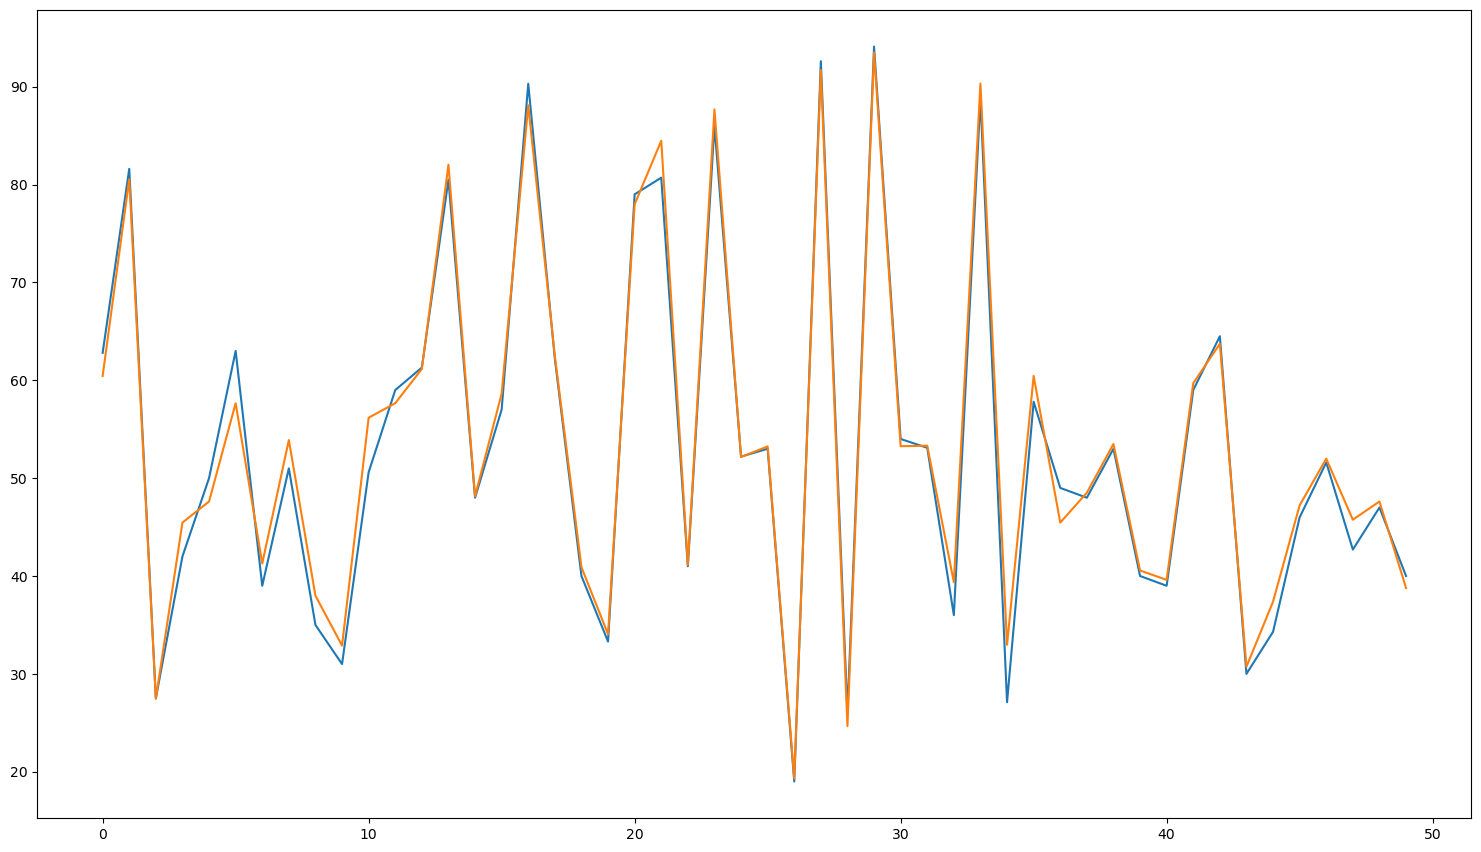

In [16]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [17]:
torch.save(model.state_dict(), "oats_lstm_1000_2_128")